In [1]:
# Python imports, put at the top for simplicity
from logaut import ltl2dfa
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from pylogics.parsers import parse_ltl

from docs.notebooks.utils import render_mdp_dfa
from docs.notebooks.utils import render_service, print_policy_data, \
    print_value_function, print_q_value_function
from stochastic_service_composition.declare_utils import exactly_once, absence_2, alt_succession, alt_precedence, \
    build_declare_assumption, not_coexistence
from stochastic_service_composition.dfa_target import mdp_from_dfa
from stochastic_service_composition.momdp import compute_final_mdp
from stochastic_service_composition.services import build_service_from_transitions, Service
from mdp_dp_rl.processes.det_policy import DetPolicy
from stochastic_service_composition.dfa_target import MdpDfa



In [2]:
# default economic cost value
DEFAULT_REWARD_ECONOMIC_COST = -1.0

# default quality cost value
DEFAULT_REWARD_QUALITY_COST = -1.0

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = -2.0

# default probability of being broken after an action
DEFAULT_BROKEN_PROB = 0.05

# default discount factor
GAMMA = 0.99

HIGH_COST = -2.0
LOW_COST = -0.5

In [3]:
# all the atomic actions for the task
BUILD_RETRIEVE_STATOR = "build_retrieve_stator"
BUILD_RETRIEVE_ROTOR = "build_retrieve_rotor"
BUILD_RETRIEVE_INVERTER = "build_retrieve_inverter"
ASSEMBLE_MOTOR = "assemble_motor"
PAINTING = "painting"
RUNNING_IN = "running_in"
ELECTRIC_TEST = "electric_test"
STATIC_TEST = "static_test"

ALL_SYMBOLS = {
    BUILD_RETRIEVE_STATOR,
    BUILD_RETRIEVE_ROTOR,
    BUILD_RETRIEVE_INVERTER,
    ASSEMBLE_MOTOR,
    PAINTING,
    RUNNING_IN,
    ELECTRIC_TEST,
    STATIC_TEST,
}

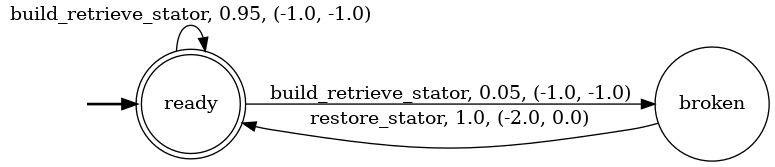

In [4]:
def stator_builder_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST, broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD) -> Service:
    """Build the stator builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob
    transitions = {
        "ready": {
          BUILD_RETRIEVE_STATOR: ({"ready": success_prob, "broken": broken_prob}, (economic_cost, quality_cost)),
        },
        "broken": {
            "restore_stator": ({"ready": 1.0}, (broken_reward, 0.0)),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore

service_stator_builder = stator_builder_service(DEFAULT_REWARD_ECONOMIC_COST, DEFAULT_REWARD_QUALITY_COST)
render_service(service_stator_builder)

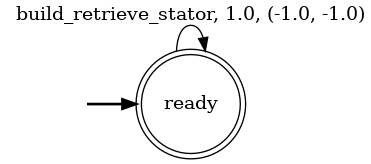

In [5]:
def stator_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the stator warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_STATOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_stator_warehouse = stator_warehouse_service(DEFAULT_REWARD_ECONOMIC_COST, DEFAULT_REWARD_QUALITY_COST)
render_service(service_stator_warehouse)

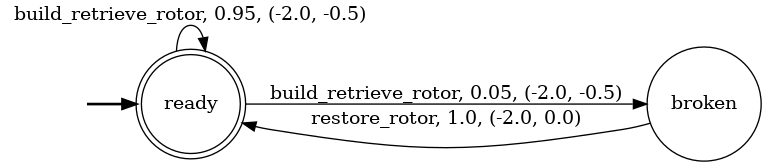

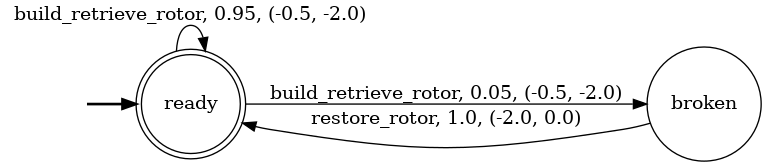

In [6]:
def rotor_builder_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST, broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD) -> Service:
    """Build the rotor builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob
    transitions = {
        "ready": {
          BUILD_RETRIEVE_ROTOR: ({"ready": success_prob, "broken": broken_prob}, (economic_cost, quality_cost)),
        },
        "broken": {
            "restore_rotor": ({"ready": 1.0}, (broken_reward, 0.0)),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore

# high economic cost - low quality cost
service_rotor_builder_1 = rotor_builder_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_rotor_builder_2 = rotor_builder_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_rotor_builder_1)
render_service(service_rotor_builder_2)

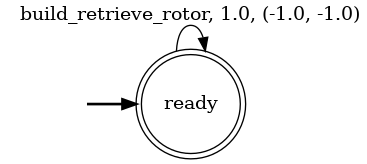

In [7]:
def rotor_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the rotor warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_ROTOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_rotor_warehouse = rotor_warehouse_service(DEFAULT_REWARD_ECONOMIC_COST, DEFAULT_REWARD_QUALITY_COST)
render_service(service_rotor_warehouse)

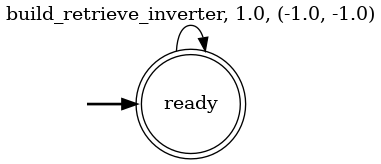

In [8]:
def inverter_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the inverter warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_INVERTER: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_inverter_warehouse = inverter_warehouse_service(DEFAULT_REWARD_ECONOMIC_COST, DEFAULT_REWARD_QUALITY_COST)
render_service(service_inverter_warehouse)

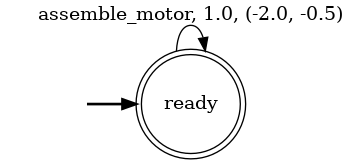

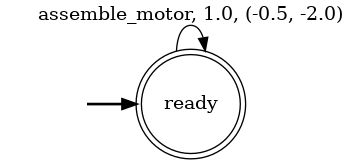

In [9]:
def assembler_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the assembler device."""
    transitions = {
        "ready": {
            ASSEMBLE_MOTOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_assembler_1 = assembler_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_assembler_2 = assembler_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)
render_service(service_assembler_1)
render_service(service_assembler_2)

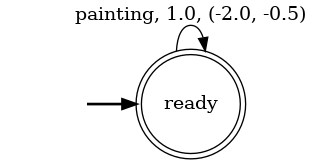

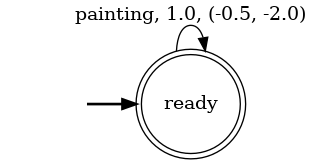

In [10]:
def painter_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the painter device."""
    transitions = {
        "ready": {
            PAINTING: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_painter_1 = painter_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_painter_2 = painter_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_painter_1)
render_service(service_painter_2)

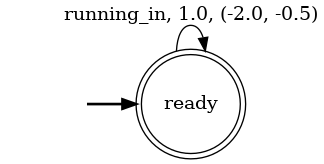

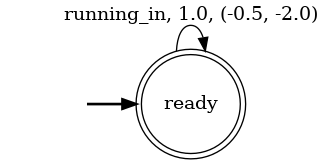

In [11]:
def smart_tester_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the smart tester device."""
    transitions = {
        "ready": {
            RUNNING_IN: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_smart_tester_1 = smart_tester_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_smart_tester_2 = smart_tester_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_smart_tester_1)
render_service(service_smart_tester_2)

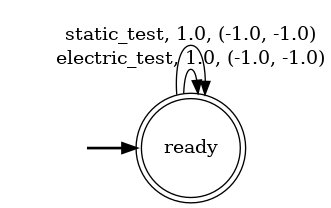

In [12]:
def mechanical_engineer_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the mechanical engineer device."""
    transitions = {
        "ready": {
            ELECTRIC_TEST: ({"ready": 1.0}, (economic_cost, quality_cost)),
            STATIC_TEST: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_mechanical_engineer = mechanical_engineer_service(DEFAULT_REWARD_ECONOMIC_COST, DEFAULT_REWARD_QUALITY_COST)
render_service(service_mechanical_engineer)

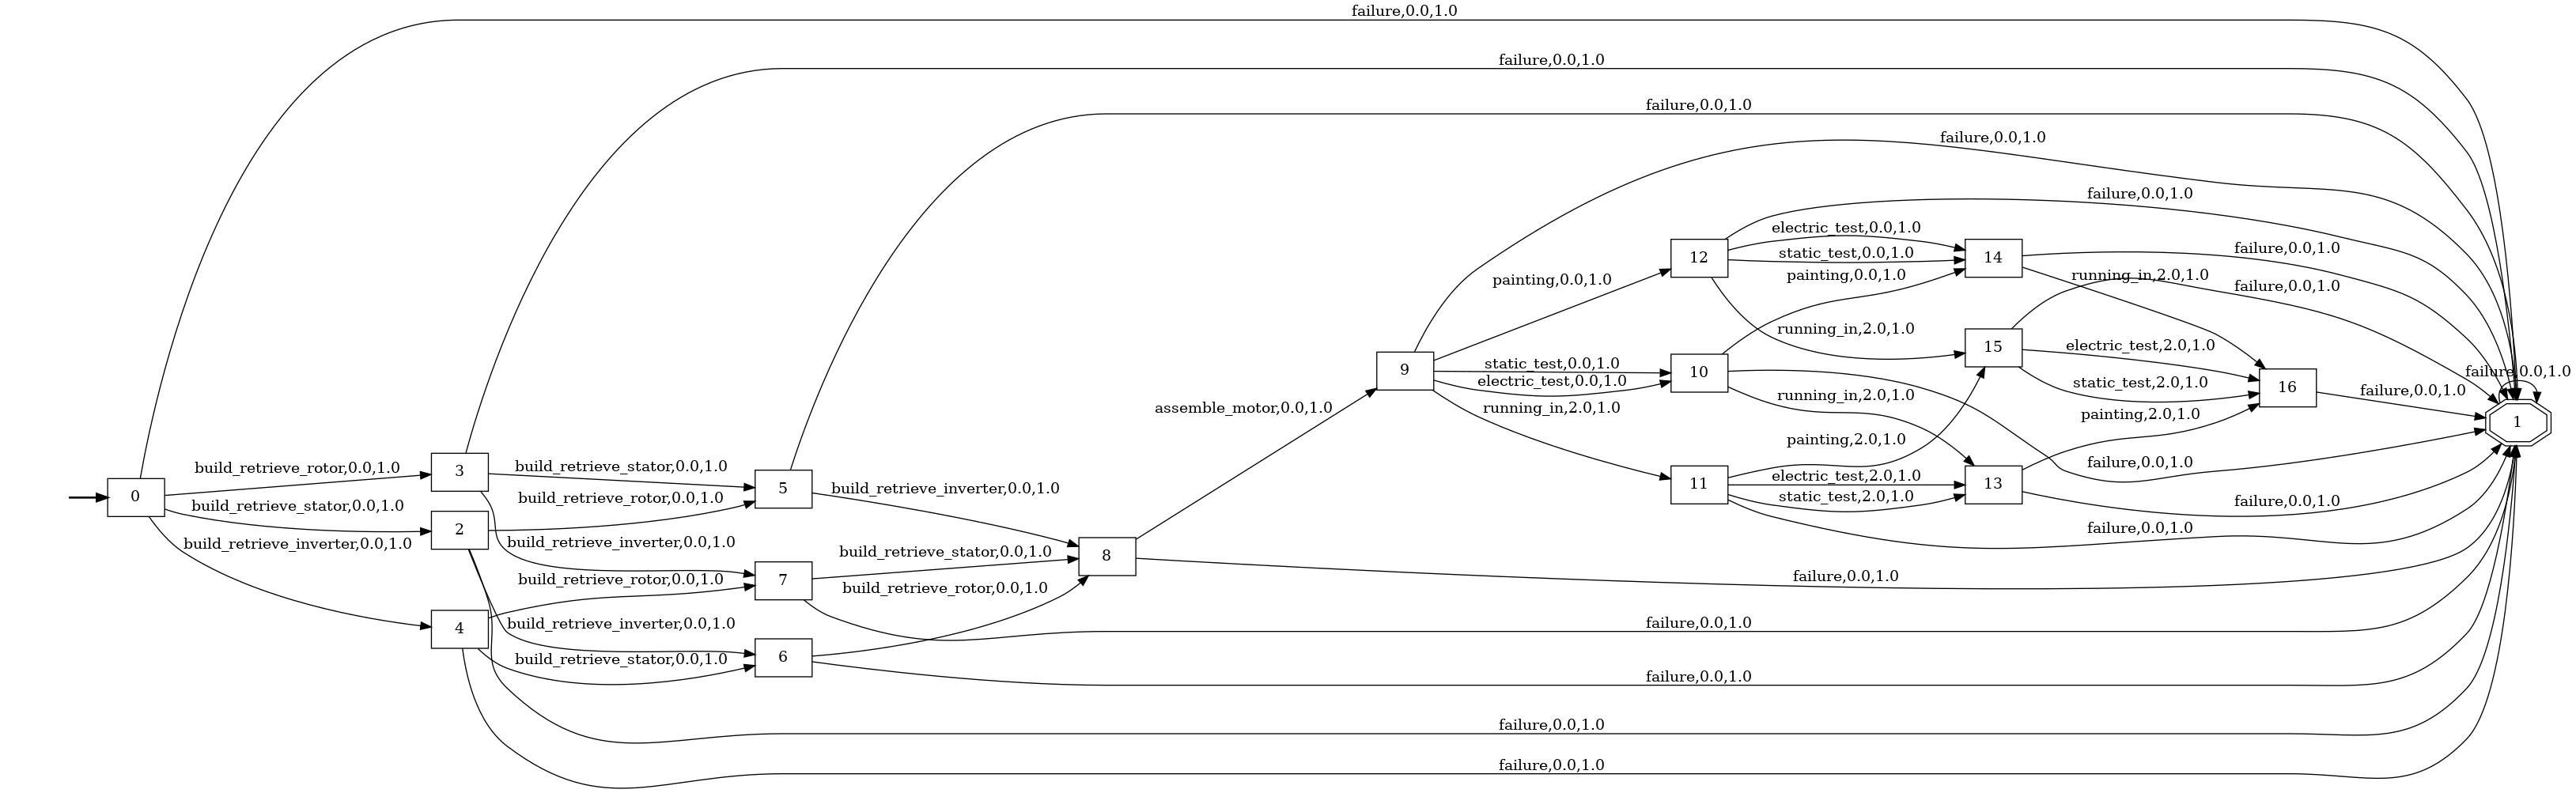

In [13]:

declare_constraints = [
    exactly_once(BUILD_RETRIEVE_STATOR),
    exactly_once(BUILD_RETRIEVE_ROTOR),
    exactly_once(BUILD_RETRIEVE_INVERTER),
    exactly_once(RUNNING_IN),
    exactly_once(ASSEMBLE_MOTOR),
    absence_2(ELECTRIC_TEST),
    absence_2(PAINTING),
    absence_2(STATIC_TEST),
    alt_succession(BUILD_RETRIEVE_STATOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_ROTOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_INVERTER, ASSEMBLE_MOTOR),
    alt_succession(ASSEMBLE_MOTOR, RUNNING_IN),
    alt_precedence(ASSEMBLE_MOTOR, PAINTING),
    alt_precedence(ASSEMBLE_MOTOR, ELECTRIC_TEST),
    alt_precedence(ASSEMBLE_MOTOR, STATIC_TEST),
    not_coexistence(ELECTRIC_TEST, STATIC_TEST),
    build_declare_assumption(ALL_SYMBOLS),
]
formula_str = " & ".join(map(lambda s: f"({s})", declare_constraints))
formula = parse_ltl(formula_str)
automaton = ltl2dfa(formula, backend="lydia")
target_mdp = mdp_from_dfa(automaton, gamma=GAMMA)
render_mdp_dfa(target_mdp)

In [14]:
all_services = [
    service_stator_builder,
    service_stator_warehouse,
    service_rotor_builder_1,
    service_rotor_builder_2,
    service_rotor_warehouse,
    service_inverter_warehouse,
    service_assembler_1,
    service_assembler_2,
    service_painter_1,
    service_painter_2,
    service_smart_tester_1,
    service_smart_tester_2,
    service_mechanical_engineer,
]


## Economic cost > Quality cost

In the following, we compute the composition MOMDP by giving more weight to the economic cost (`2.0`) rather than the quality cost (`1.0`). The optimal solution will prefer using services whose economic cost of performing the main action is lower.


In [15]:
def execute_n_action_of_policy(mdp: MdpDfa, policy: DetPolicy, n):
    current_state = mdp.initial_state
    for _ in range(n):
        action = opt_policy.get_action_for_state(current_state)
        next_state_dist = final_mdp.transitions[current_state][action]
        reward = final_mdp.rewards[current_state][action]
        next_state_highest_prob = max(next_state_dist.items(), key=lambda pair: pair[1])[0]
        print(f"action={action}, reward={reward}")
        current_state = next_state_highest_prob

In [16]:
weights = [10.0, 2.0, 1.0]
final_mdp = compute_final_mdp(target_mdp, all_services, weights)
print("Number of states: ", len(final_mdp.all_states))
opn = DPAnalytic(final_mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

Number of states:  80


In [17]:
print_policy_data(opt_policy)

Policy:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('build_retrieve_stator', 1)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('build_retrieve_stator', 1)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	Action=('build_retrieve_inverter', 5)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	Action=('assemble_motor', 7)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	Action=('running_in', 11)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	Action=('running_in', 11)
State=(

In [18]:
print_value_function(value_function)

Value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-299.9999999999997
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-299.9999999999998
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	value=-241.7800997999997
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	value=-241.19201999999973
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	value=-240.59799999999973
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	value=-260.19999999999976
State=(('broken', 'ready', 'broken', 

In [19]:
print_q_value_function(q_value_function)

Q-value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1):
	Action=('assemble_motor', 6),	Value=-301.4999999999997
	Action=('assemble_motor', 7),	Value=-299.9999999999997
	Action=('build_retrieve_inverter', 5),	Value=-299.9999999999997
	Action=('build_retrieve_rotor', 4),	Value=-299.9999999999997
	Action=('build_retrieve_stator', 1),	Value=-299.9999999999997
	Action=('electric_test', 12),	Value=-299.9999999999997
	Action=('painting', 8),	Value=-301.4999999999997
	Action=('painting', 9),	Value=-299.9999999999997
	Action=('restore_rotor', 2),	Value=-300.9999999999998
	Action=('restore_rotor', 3),	Value=-300.9999999999998
	Action=('restore_stator', 0),	Value=-300.9999999999998
	Action=('running_in', 10),	Value=-301.4999999999997
	Action=('running_in', 11),	Value=-299.9999999999997
	Action=('static_test', 12),	Value=-299.9999999999997

State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 

In [20]:
execute_n_action_of_policy(final_mdp, opt_policy, 7)

action=('build_retrieve_stator', 0), reward=-3.0
action=('build_retrieve_rotor', 3), reward=-3.0
action=('build_retrieve_inverter', 5), reward=-3.0
action=('assemble_motor', 7), reward=-3.0
action=('running_in', 11), reward=17.0
action=('painting', 9), reward=17.0
action=('electric_test', 12), reward=17.0


## Quality cost > Economic cost

In the following, we compute the composition MOMDP by giving more weight to the quality cost rather than the economic cost. The optimal solution will prefer using services whose economic cost of performing the main action is lower.


In [21]:
weights = [10.0, 1.0, 5.0]
final_mdp = compute_final_mdp(target_mdp, all_services, weights)
print("Number of states: ", len(final_mdp.all_states))
opn = DPAnalytic(final_mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

Number of states:  80


In [22]:
print_policy_data(opt_policy)

Policy:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('restore_stator', 0)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	Action=('restore_stator', 0)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	Action=('build_retrieve_inverter', 5)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	Action=('assemble_motor', 6)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	Action=('running_in', 10)
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	Action=('running_in', 10)
State=(('broken', 're

In [23]:
print_value_function(value_function)

Value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-431.1336350643165
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1),	value=-433.4683182467843
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 5),	value=-378.9995289595786
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 8),	value=-376.7672009692712
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 9),	value=-376.0274757265366
State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 10),	value=-393.99729871367333
State=(('broken', 'ready', 'broken', 'r

In [24]:
print_q_value_function(q_value_function)

Q-value function:
State=(('broken', 'ready', 'broken', 'broken', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready', 'ready'), 1):
	Action=('assemble_motor', 6),	Value=-431.3222987136733
	Action=('assemble_motor', 7),	Value=-437.3222987136733
	Action=('build_retrieve_inverter', 5),	Value=-432.8222987136733
	Action=('build_retrieve_rotor', 4),	Value=-432.8222987136733
	Action=('build_retrieve_stator', 1),	Value=-432.8222987136733
	Action=('electric_test', 12),	Value=-432.8222987136733
	Action=('painting', 8),	Value=-431.3222987136733
	Action=('painting', 9),	Value=-437.3222987136733
	Action=('restore_rotor', 2),	Value=-431.1336350643164
	Action=('restore_rotor', 3),	Value=-431.1336350643164
	Action=('restore_stator', 0),	Value=-431.1336350643164
	Action=('running_in', 10),	Value=-431.3222987136733
	Action=('running_in', 11),	Value=-437.3222987136733
	Action=('static_test', 12),	Value=-432.8222987136733

State=(('broken', 'ready', 'broken', 'ready', 'ready', 'ready', 

In [25]:
execute_n_action_of_policy(final_mdp, opt_policy, 7)

action=('build_retrieve_rotor', 2), reward=-4.5
action=('build_retrieve_stator', 0), reward=-6.0
action=('build_retrieve_inverter', 5), reward=-6.0
action=('assemble_motor', 6), reward=-4.5
action=('running_in', 10), reward=15.5
action=('painting', 8), reward=15.5
action=('electric_test', 12), reward=14.0
